# Manish Kanuri
# NUID: 002315456

# importing libraries

In [128]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import confusion_matrix, silhouette_score, adjusted_rand_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
import nltk
import gensim
import string
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.datasets import fetch_20newsgroups
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix




In [130]:
# Load 20 Newsgroups dataset (selecting 10 groups)
categories = [
    'alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 
    'comp.sys.mac.hardware', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 
    'rec.sport.hockey', 'sci.crypt'
]
newsgroups = fetch_20newsgroups(subset='all', categories=categories, remove=('headers', 'footers', 'quotes'))

In [132]:
# Preprocessing function
def preprocess(text):
    stop_words = set(stopwords.words('english'))
    text = text.lower()  # Lowercase
    tokens = word_tokenize(text)  # Tokenization
    tokens = [word for word in tokens if word.isalpha()]  # Remove punctuation and numbers
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return tokens


In [93]:
 #Convert text into TF-IDF features
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(newsgroups.data)


# Clustering

In [94]:
#  K-Means clustering
num_clusters = len(categories)
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
labels_pred = kmeans.fit_predict(X_tfidf)

In [95]:
# Evaluating clustering with a confusion matrix
true_labels = newsgroups.target
conf_matrix = confusion_matrix(true_labels, labels_pred)

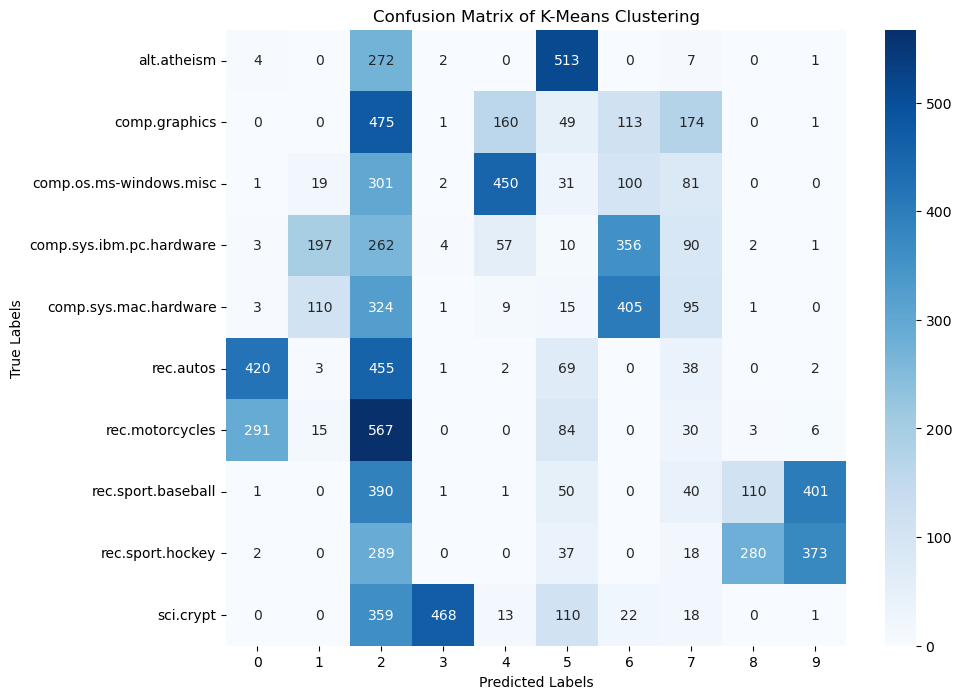

In [96]:
#  confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_clusters), yticklabels=categories)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix of K-Means Clustering")
plt.show()

In [97]:
# Loading 20 Newsgroups dataset (selecting 10 categories)
categories = [
    'alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 
    'comp.sys.mac.hardware', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 
    'rec.sport.hockey', 'sci.crypt'
]
newsgroups = fetch_20newsgroups(subset='all', categories=categories, remove=('headers', 'footers', 'quotes'))
documents = newsgroups.data
true_labels = newsgroups.target


In [98]:
# Preprocessing - Tokenization
tokenized_docs = [gensim.utils.simple_preprocess(doc) for doc in documents]

# Construct Term Frequency (TF) Matrix
tf_vectorizer = CountVectorizer(stop_words='english', max_features=5000)
X_tf = tf_vectorizer.fit_transform(documents)

# Construct TF-IDF Matrix
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(documents)

In [99]:
# Construct PPMI Matrix
def compute_ppmi(matrix):
    
    term_freqs = np.array(matrix.sum(axis=1)).flatten()  # Term frequencies
    doc_freqs = np.array(matrix.sum(axis=0)).flatten()   # Document frequencies
    total_sum = matrix.sum()
    
    expected_freqs = np.outer(term_freqs, doc_freqs) / total_sum
    with np.errstate(divide='ignore'):
        pmi_matrix = np.log((matrix.toarray() * total_sum) / (expected_freqs + 1e-10))
    
    pmi_matrix[pmi_matrix < 0] = 0  # Convert PMI to PPMI
    return pmi_matrix

X_ppmi = compute_ppmi(X_tf)

In [100]:
# Apply SVD (Reduce to 100 dimensions)
n_components = 100
svd_tf = TruncatedSVD(n_components=n_components, random_state=42)
X_svd_tf = svd_tf.fit_transform(X_tf)

svd_tfidf = TruncatedSVD(n_components=n_components, random_state=42)
X_svd_tfidf = svd_tfidf.fit_transform(X_tfidf)

svd_ppmi = TruncatedSVD(n_components=n_components, random_state=42)
X_svd_ppmi = svd_ppmi.fit_transform(X_ppmi)

In [101]:
# Train CBOW Model
cbow_model = Word2Vec(sentences=tokenized_docs, vector_size=100, window=5, min_count=5, workers=4, sg=0)
word_vectors = cbow_model.wv

# Compute Document Embeddings (Averaging Word Vectors)
def get_doc_embedding(doc, model):
    vectors = [model[word] for word in doc if word in model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

X_cbow = np.array([get_doc_embedding(doc, word_vectors) for doc in tokenized_docs])


# Apply t-SNE for Visualization

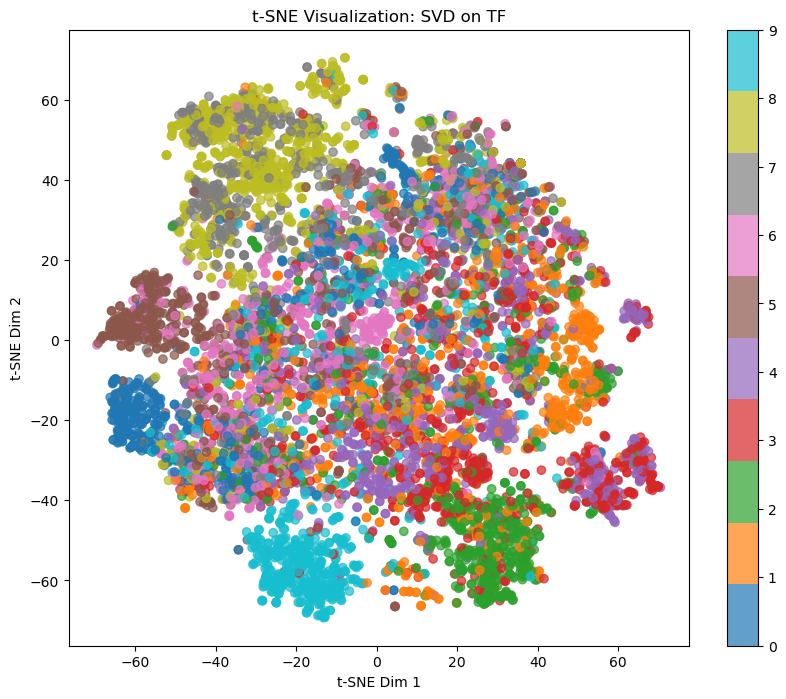

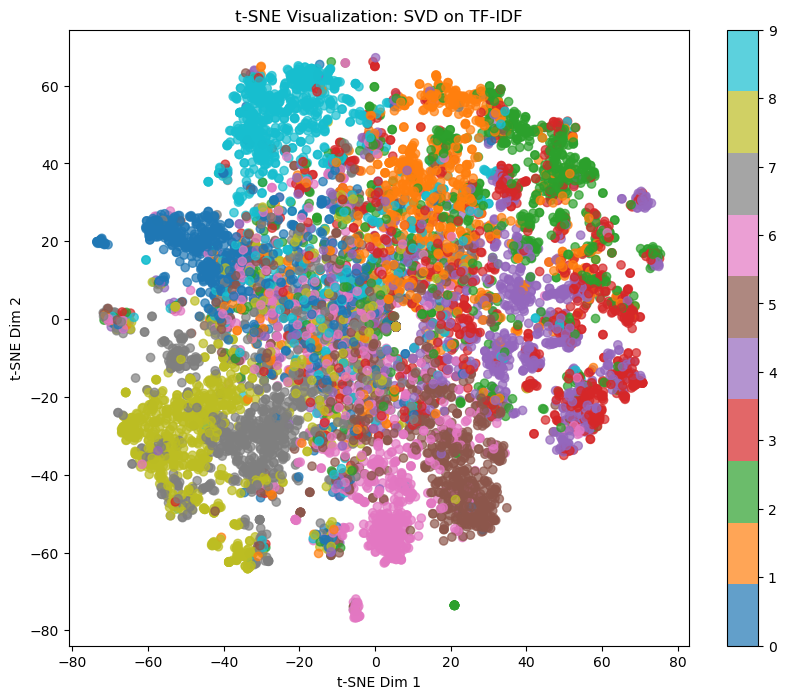

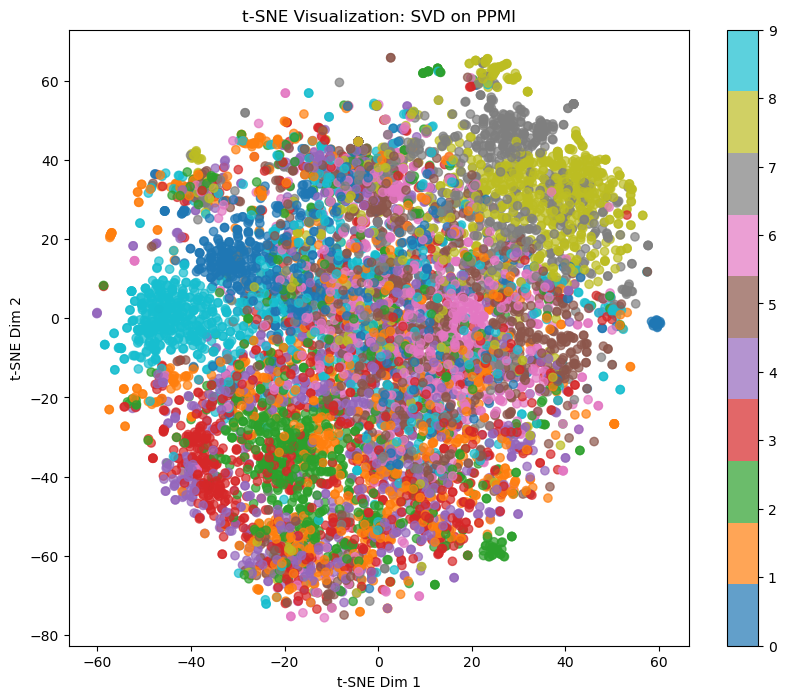

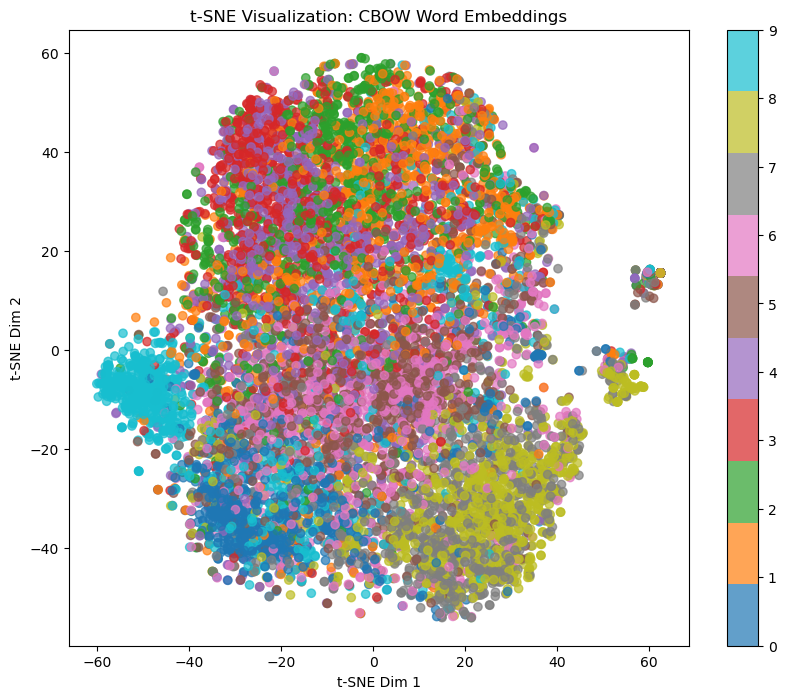

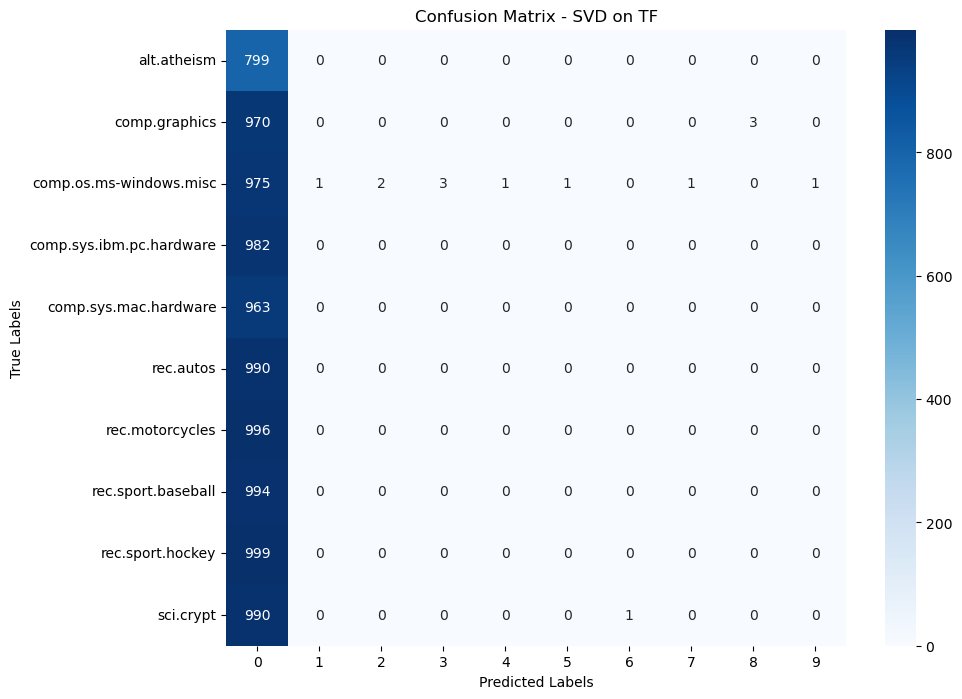

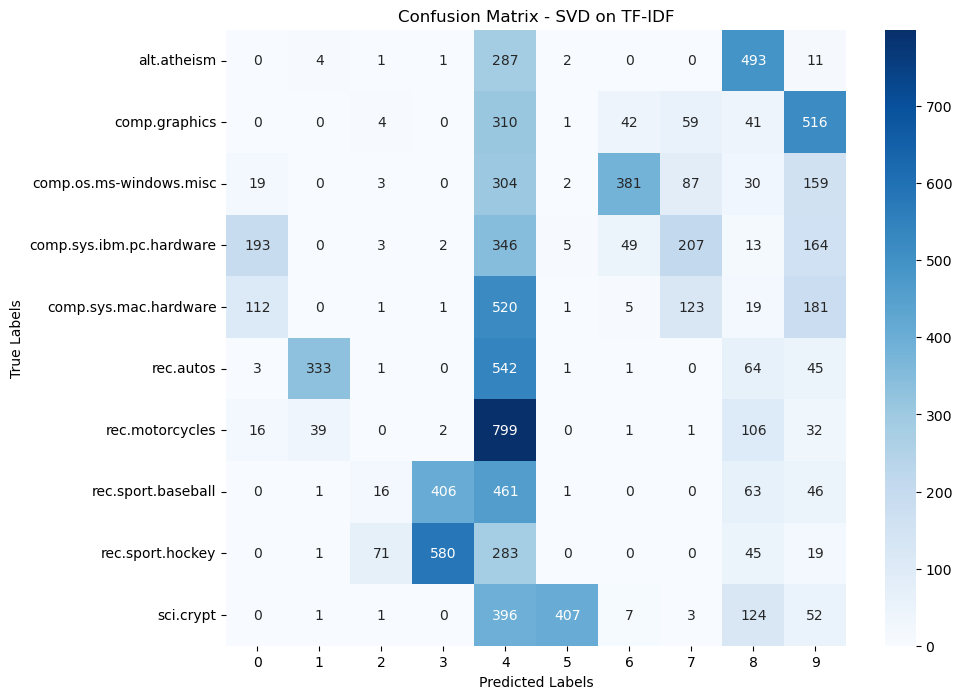

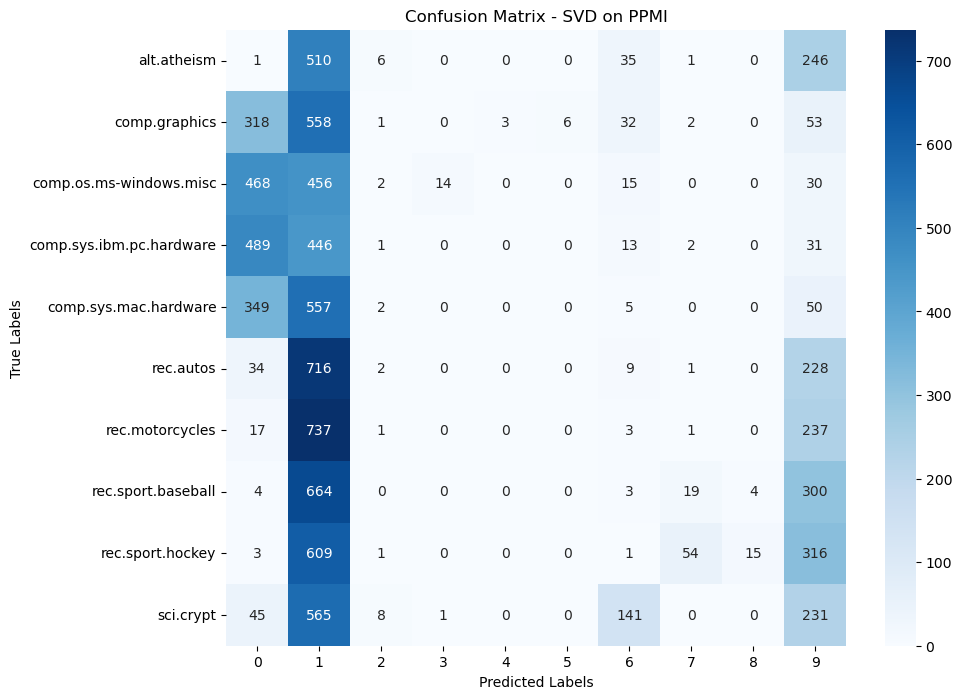

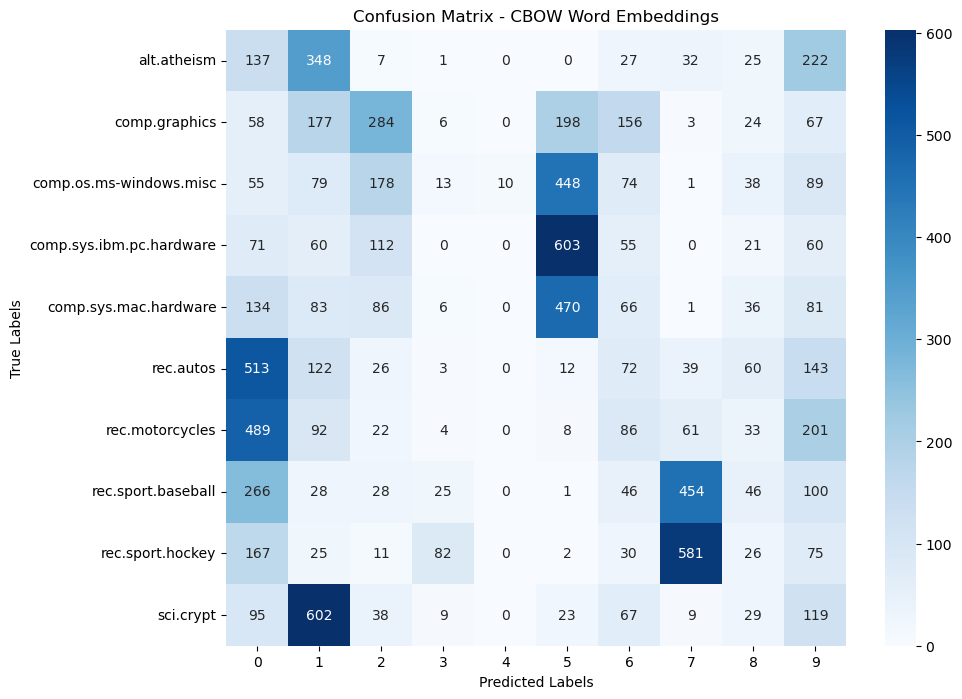

In [102]:

def plot_tsne(X, title):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    X_tsne = tsne.fit_transform(X)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=true_labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, ticks=range(len(categories)))
    plt.title(f"t-SNE Visualization: {title}")
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.show()
    
    return X_tsne

X_tsne_svd_tf = plot_tsne(X_svd_tf, "SVD on TF")
X_tsne_svd_tfidf = plot_tsne(X_svd_tfidf, "SVD on TF-IDF")
X_tsne_svd_ppmi = plot_tsne(X_svd_ppmi, "SVD on PPMI")
X_tsne_cbow = plot_tsne(X_cbow, "CBOW Word Embeddings")

# Evaluate Clustering with Confusion Matrix
def evaluate_clustering(X, method_name):
    kmeans = KMeans(n_clusters=len(categories), random_state=42, n_init=10)
    labels_pred = kmeans.fit_predict(X)
    
    conf_matrix = confusion_matrix(true_labels, labels_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(len(categories)), yticklabels=categories)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix - {method_name}")
    plt.show()

# Evaluate all embeddings
evaluate_clustering(X_svd_tf, "SVD on TF")
evaluate_clustering(X_svd_tfidf, "SVD on TF-IDF")
evaluate_clustering(X_svd_ppmi, "SVD on PPMI")
evaluate_clustering(X_cbow, "CBOW Word Embeddings")


In [103]:
# Function to Evaluate Clustering with a Confusion Matrix
def evaluate_clustering(X_tsne, method_name, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels_pred = kmeans.fit_predict(X_tsne)
    
    conf_matrix = confusion_matrix(true_labels, labels_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted Clusters")
    plt.ylabel("Actual Categories")
    plt.title(f"Confusion Matrix - {method_name} ({n_clusters} Clusters)")
    plt.show()


# Evaluate Clustering for 3 Groups First

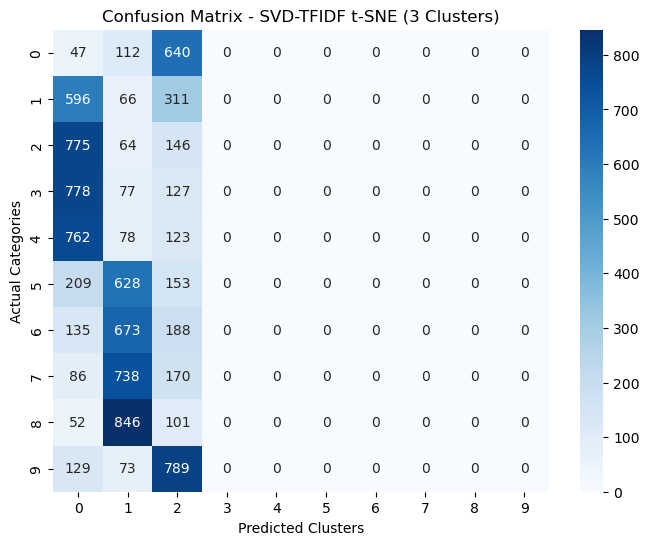

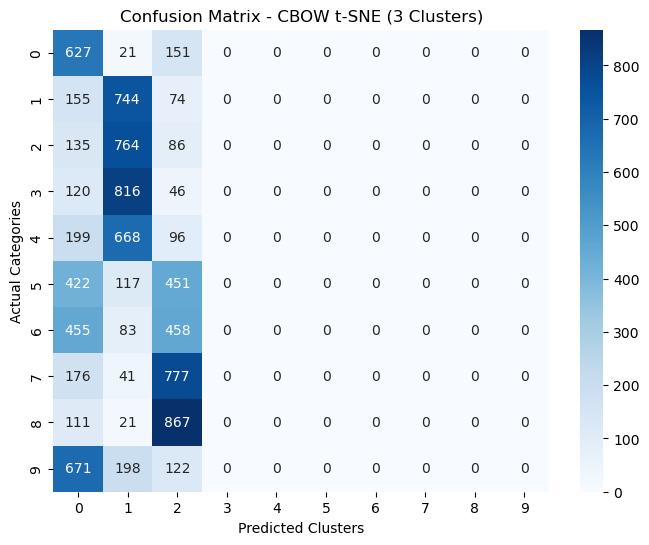

In [117]:

evaluate_clustering(X_tsne_svd_tfidf, "SVD-TFIDF t-SNE", n_clusters=3)
evaluate_clustering(X_tsne_cbow, "CBOW t-SNE", n_clusters=3)

# Evaluate Clustering for 10 Groups

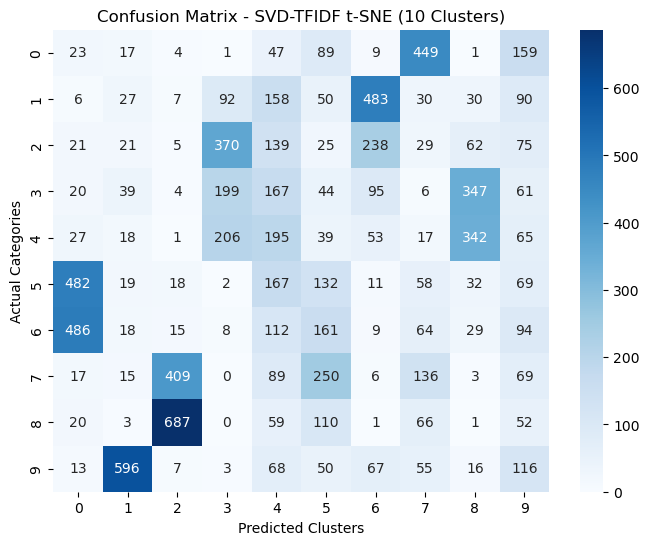

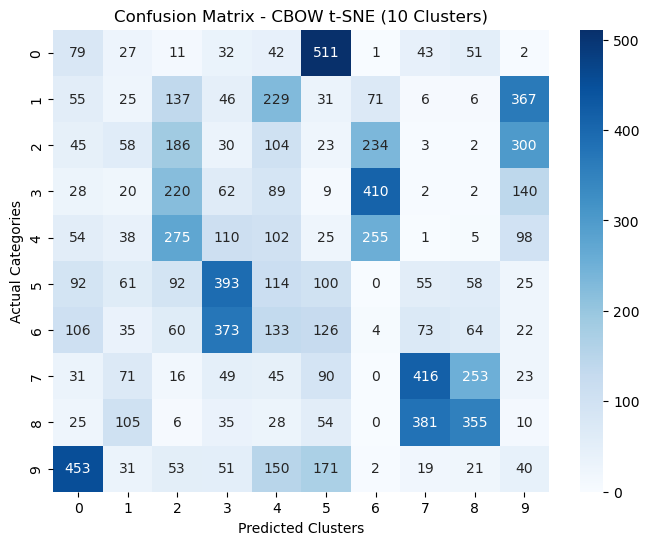

In [118]:

evaluate_clustering(X_tsne_svd_tfidf, "SVD-TFIDF t-SNE", n_clusters=10)
evaluate_clustering(X_tsne_cbow, "CBOW t-SNE", n_clusters=10)